In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from utils.folder import ImageFolder
from utils.common_utils import *
import visdom
import numpy as np

vis = visdom.Visdom()

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.Grayscale(num_output_channels=3),
#         transforms.Resize(400),
#         transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5, 0.75], [0.225, 0.225, 0.225,0.225])
    ]),
    'val': transforms.Compose([
#         transforms.Grayscale(num_output_channels=3),
#         transforms.Resize(400),
        transforms.RandomResizedCrop(224),
#         transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5, 0.75], [0.225, 0.225, 0.225, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [3]:
use_gpu

True

In [4]:
dataset_sizes

{'train': 192, 'val': 48}

In [5]:
# def pil_loader(path):
#     # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
#     with open(path, 'rb') as f:
#         img = Image.open(f)
#         return img.convert('RGB')

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



tensor(0.9995) tensor(0.9676) tensor(1.0710) tensor(1.0728)
tensor(-0.7113) tensor(-0.1871) tensor(0.2949) tensor(-0.1396)
1.1111112
-1.1023964


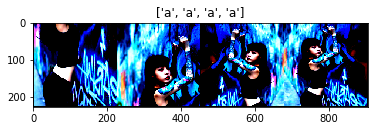

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
# print("_inputs.shape=",_inputs.shape)
# Make a grid from batch
inputs = _inputs[:,0:3,:,:]
alphas = _inputs[:,3:4,:,:]
stdr = torch.std(torch.FloatTensor(_inputs[:,0,:,:]))
stdg = torch.std(torch.FloatTensor(_inputs[:,1,:,:]))
stdb = torch.std(torch.FloatTensor(_inputs[:,2,:,:]))
stda = torch.std(torch.FloatTensor(_inputs[:,3,:,:]))

meanr = torch.mean(torch.FloatTensor(_inputs[:,0,:,:]))
meang = torch.mean(torch.FloatTensor(_inputs[:,1,:,:]))
meanb = torch.mean(torch.FloatTensor(_inputs[:,2,:,:]))
meana = torch.mean(torch.FloatTensor(_inputs[:,3,:,:]))

print(stdr,stdg,stdb,stda)
print(meanr,meang,meanb,meana)
# print(alphas)
print(np.max(alphas.numpy()))
print(np.min(alphas.numpy()))
# print("inputs.shape=",inputs.shape)
out = torchvision.utils.make_grid(inputs)
# print(out.shape)
imshow(out, title=[class_names[x] for x in classes])

In [7]:
# vis.image(out,win='in')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [16]:
def RGBAShow(rgb_np,a_np1=None,a_np2=None,phase = ''):
    vis.image(rgb_np,win = phase+'rgb',opts=dict(title=phase+'rgb'))
    if a_np1 is not None:
        #out_np1 = np.concatenate((rgb_np,a_np1),axis=0)
        out_np1 = rgb_np*a_np1
#         vis.image(out_np1,win = phase+'a1',opts=dict(title=phase+'a1'))
        vis.image(a_np1*255,win = phase+'a1_mask',opts=dict(title=phase+'a1_mask'))
    if a_np2 is not None:
        #out_np2 = np.concatenate((rgb_np,a_np2),axis=0)
        out_np2 = rgb_np*a_np2
#         vis.image(out_np2,win = phase+'a2',opts=dict(title=phase+'a2'))
        vis.image((a_np2+1)*0.5*255,win = phase+'a2_mask',opts=dict(title=phase+'a2_mask'))
        

In [17]:
def plotLosses():
    plt.plot(all_losses['train'],label='train')
    plt.plot(all_losses['val'],label='val')
    plt.legend()


In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    all_losses={'train':[],'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs ,labels没有用，只是必须有这层结构
                _inputs, labels = data
                #把alpha通道拆出来，作为label,剩下的作为rgb3通道input
#                 print('_inputs.shape=',_inputs.shape)
                inputs = (_inputs[:,0:3,:,:].sum(1)*0.3).reshape(4,1,224,224)
                labels = _inputs[:,3:4,:,:]
#                 labels = (labels-0.5)*2
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                #print('outputs mean =',torch.mean(outputs),torch.min(outputs),torch.max(outputs))
                #print('========= outputs===================',outputs[0])
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data.item() * inputs.size(0)
                #show sample
                RGBAShow(inputs.cpu().detach().numpy()[0], a_np1= labels.cpu().detach().numpy()[0], a_np2 = outputs.cpu().detach().numpy()[0],phase = phase)

            epoch_loss = running_loss / dataset_sizes[phase]
            all_losses[phase].append(epoch_loss)
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'train' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,all_losses

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [19]:
from models.skip import skip
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01
OPTIMIZER='adam' # 'LBFGS'
show_every = 500
num_iter=2400
input_depth = 1
figsize = 5 
dtype = (torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

net = skip(
            input_depth, 1, 
            num_channels_down = [8, 16, 32, 64, 128, 128, 128 ], 
            num_channels_up   = [8, 16, 32, 64, 128, 128, 128 ],
            num_channels_skip = [4,  4,  4,  4,   4,   4,   4 ], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype)
# print(net)

In [20]:
# for param in net.parameters():
#     print(type(param.data), param.size())
#     print(param.data)

# s = sum([np.prod(list(p.size())) for p in net.parameters() ])
# print(s)

In [21]:
# weights initializing is far important than you imaging
# learn from inpainting
for n in [x for x in net.parameters()]:
    n.data.normal_()

In [22]:
model_ft = net

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.MSELoss().type(dtype)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [23]:
model_ft,all_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


/home/yuan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


train Loss: 2.1276
val Loss: 2.0043
Epoch 1/19
----------
train Loss: 1.8968
val Loss: 1.8454
Epoch 2/19
----------
train Loss: 1.5839
val Loss: 1.4466
Epoch 3/19
----------
train Loss: 1.3525
val Loss: 1.3148
Epoch 4/19
----------
train Loss: 1.2320
val Loss: 1.1975
Epoch 5/19
----------
train Loss: 1.1572
val Loss: 1.1117
Epoch 6/19
----------
train Loss: 1.0935
val Loss: 1.0783
Epoch 7/19
----------
train Loss: 1.0721
val Loss: 1.1020
Epoch 8/19
----------
train Loss: 1.0745
val Loss: 1.0529
Epoch 9/19
----------
train Loss: 1.0682
val Loss: 1.0859
Epoch 10/19
----------
train Loss: 1.0666
val Loss: 1.0949
Epoch 11/19
----------
train Loss: 1.0677
val Loss: 1.0680
Epoch 12/19
----------
train Loss: 1.0614
val Loss: 1.1521
Epoch 13/19
----------
train Loss: 1.0537
val Loss: 1.0640
Epoch 14/19
----------
train Loss: 1.0505
val Loss: 1.0964
Epoch 15/19
----------
train Loss: 1.0521
val Loss: 1.1042
Epoch 16/19
----------
train Loss: 1.0506
val Loss: 1.0852
Epoch 17/19
----------
train 

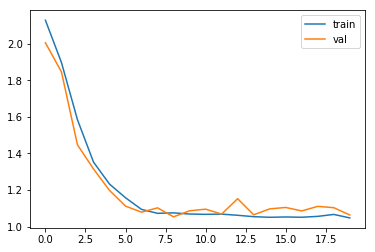

In [24]:
plotLosses()

In [25]:
# Show a picture 

# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch
inputs = _inputs[:,0:3,:,:]

# print(inputs[0])
inputs_a = _inputs[:,3:4,:,:]
if use_gpu:
    inputs = Variable(inputs.cuda())

model_ft.train(False)    
outs = model_ft(inputs)

# print(outs.cpu()[0])

_inputs.shape= torch.Size([4, 4, 224, 224])


RuntimeError: Given groups=1, weight[4, 1, 1, 1], so expected input[4, 3, 224, 224] to have 1 channels, but got 3 channels instead

In [ ]:
rgb_batch = inputs.cpu().detach().numpy()
np_to_pil(rgb_batch[0]).save('rgb.jpg')

a2_batch = outs.cpu().detach().numpy()
a1_batch = inputs_a.cpu().detach().numpy()
rgba_batch = np.concatenate((rgb_batch,a2_batch),axis=1)

rgba_np=rgba_batch[0]
rgba_pil = np_to_pil(rgba_np)
rgba_pil.show()
rgba_pil.save('rgba.png')



In [ ]:
RGBAShow(rgb_batch[0],a_np1=a1_batch[0],a_np2=a2_batch[0])


In [ ]:
# def RGBAShowBatch(rgb_np,a_np):
#     out_np = np.concatenate((rgb_np,a_np),axis=1)
#     vis.images(out_np,win='out',opts=dict(caption='out list'),)

# RGBAShowBatch(rgb_batch,a_batch)

In [ ]:
np.min(a2_batch)

In [ ]:
np_to_pil(inputs.cpu().detach().numpy()[0]).save('input.jpg')

In [ ]:

_inputs, classes = next(iter(dataloaders['train']))
ii = _inputs.cpu().detach().numpy()[0]
print(ii.shape)
# print(ii[0])
# print(ii[1])
# print(ii[2])


def dumpnp(a):
    for h in range(a.shape[0]):
        print('[{0}]'.format(h),end='')
        for i in range (a.shape[1]):
            print('[{0}][{1}]'.format(h,i),end='')
            for j in range(a.shape[2]):
                print(a[h][i][j],',',end='')
            print("")
        print("")
def dumpnp2(a):
    for i in range (a.shape[1]):
        print('[{0}]'.format(i),end='')
        for j in range(a.shape[2]):
            print(a[0][i][j]+a[1][i][j]+a[2][i][j],',',end='')
        print("")
    print("")
                
dumpnp2(ii)

In [ ]:
np_to_pil(ii[0:3,:,:]).save('_input.png')

In [ ]:
model_ft